# Imports

In [737]:
#basics
import pandas as pd 
import numpy as np

#plotting
import matplotlib.pyplot as plt
import seaborn as sns
import pygal

#files
import glob
import pickle

#spacy
import spacy
import en_core_web_sm
nlp = en_core_web_sm.load()

#text manipulation
import re
import string

#modeling
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

#user defined
from SpacyPreprocessor import SpacyPreprocessor
from TopicModeling import topic_model

In [447]:
path = '/Users/labbot/Documents/metis_bootcamp/project04/allbreeds_data/'
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    one_df = pd.read_csv(filename, index_col=None, header=0)
    li.append(one_df)

df_raw = pd.concat(li, axis=0, ignore_index=True)

/Users/labbot/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (19) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/Users/labbot/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (18) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [738]:
df_raw.head(2)

,body,score_hidden,archived,name,author,author_flair_text,downs,created_utc,subreddit_id,link_id,parent_id,score,retrieved_on,controversiality,gilded,id,subreddit,ups,distinguished,author_flair_css_class
1,Our lily is 12 and deaf and blind. Always fun ...,NaN,NaN,NaN,CorgiRawr,Jaxson and Lily (Pembrokes),NaN,1559174562,t5_2rdw8,t3_bufjgt,t3_bufjgt,2,1563728193,0,0,epdv5nc,corgi,NaN,NaN,NaN
2,Our little one is still teething. Lost a few t...,NaN,NaN,NaN,sixmileswest,Lucy the Pembroke Corgi,NaN,1558916488,t5_2rdw8,t3_bt9lwm,t1_eowu0ye,2,1563437838,0,0,eowy57e,corgi,NaN,NaN,NaN


In [449]:
df_raw.shape

(470087, 20)

In [450]:
df_raw.nunique()

body                      414057
score_hidden                   0
archived                       0
name                           0
author                     76777
author_flair_text           1127
downs                          0
created_utc               465666
subreddit_id                   7
link_id                    82195
parent_id                 222183
score                        385
retrieved_on              463015
controversiality               2
gilded                         3
id                        470087
subreddit                      7
ups                            0
distinguished                  1
author_flair_css_class         3
dtype: int64

In [451]:
df_raw.isnull().sum()

body                           2
score_hidden              470087
archived                  470087
name                      470087
author                         0
author_flair_text         444168
downs                     470087
created_utc                    0
subreddit_id                   0
link_id                        0
parent_id                      0
score                          0
retrieved_on                   0
controversiality               0
gilded                         0
id                             0
subreddit                      0
ups                       470087
distinguished             465909
author_flair_css_class    469728
dtype: int64

In [452]:
df_raw['subreddit'].value_counts()

pitbulls            141515
germanshepherds      72597
corgi                67215
Dachshund            64995
goldenretrievers     55851
shiba                39201
labrador             28713
Name: subreddit, dtype: int64

In [453]:
# need to drop the two rows where comment body is missing
df_raw = df_raw.dropna(subset = ['body'])
df_raw.shape

(470085, 20)

In [454]:
# remove posts from an automoderator
df_raw = df_raw[df_raw['author'] != 'AutoModerator']
df_raw.shape

(466148, 20)

In [455]:
# document = all comments on a given post
df = df_raw.groupby(['link_id','subreddit'], as_index = False).agg({'body': ' '.join})

# write final df to pickle
with open('document_df.pickle', 'wb') as to_write:
    pickle.dump(df, to_write)

# check how many documents this yielded
df.shape

(79068, 3)

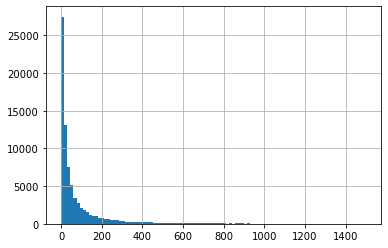

In [456]:
# check the length of newly created documents
df['doc_length'] = df['body'].str.split().str.len()
df['doc_length'][df['doc_length'] < 1500].hist(bins=100);

In [739]:
df['doc_length'].describe()

count    79068.000000
mean       103.041230
std        260.327681
min          1.000000
25%         10.000000
50%         29.000000
75%         90.000000
max      10605.000000
Name: doc_length, dtype: float64

# Preprocessing

## Define Stopwords
Note: I've added to the custom stopwords list iteratively during the EDA + modeling.

In [542]:
# Create list of stopwords
stop_words = spacy_model.Defaults.stop_words

# list of words that are germane to subject that I'll treat as stop words
custom_stopwords = ['pit','bull','pitbull','dog','breed','puppy','good','love','thank',
                   'boy','girl','people','owner','like','look','know','luck','sorry','loss','lose','look',
                   'lol','haha','pron','thing', 'com','https','think','remove','want','birthday','time','year',
                    'day','oh','sure', 'post','comment','delete','sub','subreddit', 'hi', 'utm', 'reddit', 'www', 
                    'reddit', 'www', 'share', 'bot', 'amp', 'utm', 'faq', 'amp', 'imgur', 'omg', 'ah', 'hello', 
                    'try', 'right', 'find','need','come','way','use','lot','imgur gallery','imgur','gallery','gif',
                    'app','yes','let','minute','month', 'week','year','new','wow','corgi','golden retriever','golden',
                    'retriever','shiba','inu','shiba inu','dachshund','german','shepherd','german shepherd','labrador',
                    'lab','greyhound','germanshepherd','pup','life','ignoreme','source','wake','lb','lbs','ask',
                    'little','picture','stuff','np','source','ha','pibble','pittie','pitty','pic', 'wiener','shibe',
                    'link','github','autplayer','message','old','video','hour','super','ago', 'pretty','image','photo',
                    'metric', 'user' , 'cm', 'sw','ref', 'cp','subject','send', 'longer', 'opt', 'don',  'reply',  'comments',
                    'wiki','mp','version','autplaye', 'delet','downloadable','clickablelinkbot','info','ignore','ppx','request',
                    'report', 'phonebatterylevelbot', 'battery','vreddit', 'downloader','mb','beep','botwatch', 'xrrvh' ,
                    'list',  'res' , 'non' 'mobile' ,'pmdevita', 'issue', 'add', 'vredditshare', 'detect', 'levels', 'ocr', 
                    'phone' 'charge', 'index', 'preview', 'redd', 'format','sneakpeekbot', 'downvote', 'blacklist', 'branch', 
                    'manager',  'assistant','autplaye','send','hey','live']

# add custom stopwords to stopwords list
for s in custom_stopwords:
    stop_words.add(s)

## SpaCy Pipeline

In [459]:
# load spacy model
spacy_model = SpacyPreprocessor.load_model()

In [577]:
preprocessor = SpacyPreprocessor(spacy_model=spacy_model, lemmatize=True, remove_numbers=True, 
                                 remove_stopwords=False, remove_special=True, 
                                 pos_to_remove=['PROPN','ADP','SYM','NUM','AUX'])
df['spacy_pipe'] = preprocessor.preprocess_text_list(list(df['body']))

79068it [04:37, 284.42it/s]


In [576]:
# check what the spacy-processed data looks like:
df.head()

,link_id,subreddit,body,doc_length,spacy_pipe
0,t3_8z5ew2,goldenretrievers,What's the new pupper's name? Utah,6,what the pupper 's name
1,t3_8zrnvs,pitbulls,"Dude, she's beautiful!",3,pron
2,t3_90swcq,germanshepherds,Wow. I would make that into a tattoo ����,9,wow pron would make that a tattoo
3,t3_9230g8,germanshepherds,A big puppy hah,4,a puppy hah
4,t3_925zut,pitbulls,Fair enough. Perish Sorry thought you someone ...,12,fair enough think pron someone else o


In [462]:
# write cleaned df to pickle
with open('document_df_clean.pickle', 'wb') as to_write:
    pickle.dump(df, to_write)

In [101]:
# define corpus as the spacy-processed version of the data
corpus = df['spacy_pipe']

# Topic Modeling EDA
Iterate through combinations of different vectorizers and topic modeling algorithms and print top keywords to gut check which is working best with the data

## Combinations of Vectorizers and Models

In [580]:
allbreed_topics = topic_model(data=corpus,
                             vectorizer=CountVectorizer(stop_words=stop_words,min_df=10,ngram_range=(1, 2)),
                            model='lsa',num_topics=10)
allbreed_topics_cv_lsa = allbreed_topics.get_topics()

/Users/labbot/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '



Topic  0
work, walk, help, home, long, happy, great, feel, vet, big, food, start, tell, bad, training

Topic  1
beautiful, happy, sweet, heart, hope, baby, hug, cute, face, friend, feel, handsome, wish, eye, family

Topic  2
food, vet, eat, feed, diet, allergy, weight, grain, raw, chicken, free, grain free, kibble, skin, ear

Topic  3
toy, chew, destroy, ball, happy, eat, play, long, beautiful, bone, black, treat, cute, bed, crate

Topic  4
breeder, toy, ear, cute, black, mix, big, destroy, buy, rescue, shelter, tail, adorable, ball, chew

Topic  5
breeder, toy, hope, vet, feel, heart, home, surgery, hard, family, pain, help, health, friend, hug

Topic  6
collar, toy, harness, pull, leash, prong, vet, walk, prong collar, bite, pain, ball, attack, bad, destroy

Topic  7
happy, breeder, collar, training, work, happy happy, harness, train, beautiful, great, treat, rescue, crate, pull, food

Topic  8
happy, food, cat, bite, animal, aggressive, play, attack, park, eat, shelter, kid, adopt,

In [581]:
allbreed_topics = topic_model(data=corpus,
                             vectorizer=TfidfVectorizer(stop_words=stop_words,min_df=100,ngram_range=(1, 2)),
                            model='lsa',num_topics=10)
allbreed_topics_tfidf_lsa = allbreed_topics.get_topics()


Topic  0
cute, beautiful, happy, adorable, face, sweet, handsome, great, ear, baby, big, eye, gorgeous, cutie, work

Topic  1
cute, cute cute, cute pupper, adorable cute, cute adorable, face cute, ear cute, cute face, sooo cute, cute baby, cute ear, soooo cute, damn cute, cute great, cute lil

Topic  2
beautiful, cute, beautiful beautiful, gorgeous, beautiful eye, beautiful smile, beautiful face, beautiful baby, gorgeous beautiful, cute beautiful, absolutely beautiful, beautiful coat, beautiful pupper, beautiful gorgeous, beautiful cute

Topic  3
happy, happy happy, cute, beautiful, handsome, cake, happy beautiful, smile, happy cake, beautiful happy, happy handsome, cute happy, happy sweet, happy face, handsome happy

Topic  4
handsome, gorgeous, adorable, boi, face, handsome boi, ear, handsome handsome, cutie, happy handsome, eye, fella, handsome guy, handsome fella, handsome man

Topic  5
adorable, cutie, face, ear, sweet, smile, precious, gorgeous, sweet face, absolutely adorable, 

In [582]:
allbreed_topics = topic_model(data=corpus,
                             vectorizer=CountVectorizer(stop_words=stop_words,min_df=10,ngram_range=(1, 2)),
                            model='nmf',num_topics=10)
allbreed_topics_cv_nmf = allbreed_topics.get_topics()

/Users/labbot/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '



Topic  0
animal, bad, work, tell, bite, play, attack, aggressive, cat, pet, mean, small, park, big, mix

Topic  1
hope, heart, beautiful, feel, sweet, friend, hug, baby, hard, long, pain, family, rest, wish, soon

Topic  2
food, vet, eat, feed, diet, help, weight, grain, allergy, chicken, free, raw, treat, start, grain free

Topic  3
toy, chew, destroy, ball, play, long, buy, black, bone, tooth, bite, treat, antler, hard, rope

Topic  4
breeder, health, rescue, reputable, test, litter, shelter, reputable breeder, breeding, parent, work, buy, home, vet, standard

Topic  5
cute, adorable, face, beautiful, big, baby, sweet, eye, handsome, gorgeous, great, cutie, head, bed, mix

Topic  6
crate, training, bed, work, sleep, train, home, leave, night, help, treat, house, start, door, outside

Topic  7
happy, happy happy, beautiful, sweet, great, home, rescue, handsome, smile, treat, adopt, shelter, glad, amazing, awesome

Topic  8
collar, walk, harness, leash, pull, training, work, prong, pr

In [583]:
allbreed_topics = topic_model(data=corpus,
                             vectorizer=TfidfVectorizer(stop_words=stop_words,min_df=10,ngram_range=(1, 1)),
                            model='nmf',num_topics=10)
allbreed_topics_tfidf_nmf = allbreed_topics.get_topics()

/Users/labbot/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '



Topic  0
great, work, big, home, long, play, walk, bed, treat, food, toy, help, hope, feel, vet

Topic  1
cute, pupper, baby, boi, soooo, sooo, cut, lil, precious, paw, damn, smile, woof, god, doggo

Topic  2
beautiful, gorgeous, eye, smile, coat, color, great, absolutely, baby, pupper, beauty, lovely, amazing, black, lady

Topic  3
happy, smile, cake, hope, pupper, boi, doggo, bday, gorgeous, wish, hat, today, great, th, turn

Topic  4
handsome, boi, gorgeous, man, great, guy, fella, pupper, doggo, woof, big, eye, looking, dapper, thanks

Topic  5
adorable, absolutely, precious, baby, smile, eye, cut, pupper, goodness, paw, grow, mix, congrat, gorgeous, perfect

Topic  6
sweet, baby, heart, pupper, hug, precious, smile, eye, kiss, boi, hope, angel, sweetheart, dream, sweetie

Topic  7
ear, gorgeous, floppy, big, grow, mix, stand, crop, flop, eye, paw, head, cut, bat, scratch

Topic  8
cutie, pie, eye, smile, precious, gorgeous, patootie, great, perfect, real, woof, goodness, boop, ba

In [584]:
allbreed_topics = topic_model(data=corpus,
                             vectorizer=CountVectorizer(stop_words=stop_words,min_df=10,ngram_range=(1, 2)),
                            model='lda',num_topics=10)
allbreed_topics_cv_lda = allbreed_topics.get_topics()

/Users/labbot/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '



Topic  0
beautiful, sweet, heart, great, eye, friend, face, hug, hope, gorgeous, baby, feel, amazing, happy, family

Topic  1
big, long, coat, black, hair, grow, color, fur, white, red, nail, brush, pound, small, short

Topic  2
vet, crate, hope, feel, poor, soon, help, surgery, home, leave, night, baby, work, start, door

Topic  3
cute, ear, adorable, face, baby, sweet, big, mix, eye, belly, beautiful, precious, cutie, smile, rub

Topic  4
water, tail, car, harness, cute, bath, buy, work, cool, hate, wear, nice, great, cold, fit

Topic  5
bed, sleep, cat, play, couch, bark, house, sit, big, ball, run, kid, cuddle, blanket, watch

Topic  6
happy, handsome, cute, cutie, great, boi, snow, smile, adorable, pupper, happy happy, face, congrat, woof, nice

Topic  7
work, walk, training, train, treat, play, leash, start, help, learn, collar, bite, home, long, teach

Topic  8
food, eat, toy, vet, feed, ball, treat, help, chew, chicken, allergy, bone, diet, skin, free

Topic  9
breeder, rescue

In [585]:
allbreed_topics = topic_model(data=corpus,
                             vectorizer=TfidfVectorizer(stop_words=stop_words,min_df=10,ngram_range=(1, 2)),
                            model='lda',num_topics=10)
allbreed_topics_tfidf_lda = allbreed_topics.get_topics()

/Users/labbot/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '



Topic  0
happy, handsome, rescue, home, adopt, heart, happy happy, beautiful, hope, shelter, great, sweet, foster, family, work

Topic  1
ear, cute, eye, mix, perfect, awesome, adorable, snoot, snuggle, derp, twin, floppy, beautiful, big, funny

Topic  2
bed, sleep, boi, blanket, couch, sploot, precious, pillow, cat, hair, long, cute, night, friend, lay

Topic  3
gorgeous, beautiful, nice, cute, looking, woof, great, adorable, sweetie, black, majestic, handsome, eye, tongue, paw

Topic  4
cute, smile, baby, happy, hope, poor, feel, great, hug, face, cake, beautiful, wish, rest, soon

Topic  5
face, cute, belly, ball, rub, big, blep, belly rub, handsome, cool, head, adorable, doggo, fluffy, throw

Topic  6
cutie, breeder, nail, mix, mean, pie, bad, cute, cutie pie, parent, actually, meet, great, female, definitely

Topic  7
adorable, great, cute, nap, car, fun, collar, seat, cuteness, welcome, harness, congratulation, ride, costume, awww

Topic  8
food, work, toy, play, walk, vet, eat,

## LDA Viz

LDA with a Count Vectorizer seemed to work *okay* for my data, so might as well throw it into an LDAviz for some visual inspection.

In [58]:
import pyLDAvis
import pyLDAvis.sklearn

In [59]:
# create pyLDAvis with countvectorizer and save to html file
cv = CountVectorizer(stop_words=stop_words,min_df=10,ngram_range=(1, 2))
dtm_cv = cv.fit_transform(df['spacy_pipe'])

lda_cv = LatentDirichletAllocation(n_components=15, random_state=0)
lda_cv.fit(dtm_cv)

lda_cv_viz = pyLDAvis.sklearn.prepare(lda_cv, dtm_cv, cv) 
pyLDAvis.save_html(lda_cv_viz,'lda_cv_viz.html')

/Users/labbot/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


# Final Topic Model
Ultimately I think NMF with a count vectorizer is working best for my corpus, so I'll create a final version of that here.

I'll also build a CorEx model with anchors, since I'm seeing some consistent themes crop up throughout my EDA, but they aren't reliably appearing with every iteration.

## Fit final Vectorizer

In [625]:
# instantiate the vectorizer
vectorizer = CountVectorizer(stop_words=stop_words,min_df=10,ngram_range=(1, 2))

# fit and transform on corpus, save doc-term matrix
doc_word_matrix = vectorizer.fit_transform(corpus) 

# save the terms for future reference
terms = vectorizer.get_feature_names()

# check the shape of the doc-term matrix
doc_word_matrix.shape

/Users/labbot/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


(79068, 27725)

## Fit final NMF model

In [642]:
# create and fit decomposition model
nmf = NMF(n_components=8,random_state=7)

# create the document-topic matrix
doc_topic_matrix = nmf.fit_transform(doc_word_matrix)

# create columns names
topicnames = ['Topic_' + str(i) for i in range(nmf.n_components)]

# index names
docnames = ['Comment_' + str(i) for i in range(len(corpus))]

# create a dataframe
df_doc_topic = pd.DataFrame(np.round(doc_topic_matrix,4), columns=topicnames, index=docnames)

df_doc_topic.head()

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7
Comment_0,0.0000,0.0007,0.0000,0.0000,0.0000,0.0024,0.0,0.0011
Comment_1,0.0000,0.0134,0.0000,0.0000,0.0000,0.0035,0.0,0.0049
Comment_2,0.0000,0.0001,0.0000,0.0000,0.0000,0.0002,0.0,0.0000
Comment_3,0.0000,0.0000,0.0014,0.0023,0.0000,0.0134,0.0,0.0000
Comment_4,0.0005,0.0000,0.0000,0.0001,0.0003,0.0006,0.0,0.0000


## Corex

In [277]:
from corextopic import corextopic as ct

In [464]:
# What does Corex yield without any anchors?
model_cx_unanchored = ct.Corex(n_hidden=7, seed=0)
model_cx_unanchored = model_cx_unanchored.fit(
    doc_word_matrix,
    words=terms) # Tell the model how much it should rely on the anchors

for i, topic_ngrams in enumerate(model_cx_unanchored.get_topics(n_words=15)):
    topic_ngrams = [ngram[0] for ngram in topic_ngrams if ngram[1] > 0]
    print("Topic #{}: {}".format(i+1, ", ".join(topic_ngrams)))

Topic #1: vet, training, breeder, food, help, walk, crate, work, train, start, home, leash, rescue, run, bad
Topic #2: small anti, anti anti, anti, charge mistakes, mistakes, phone charge
Topic #3: efegjqb, efegjqb efegjqb, friend efegjqb, single friend
Topic #4: doppelg, doppelg nger, nger
Topic #5: 
Topic #6: 
Topic #7: 


Yikes! Not great. Corex without anchors seems to pick up mostly reddit-related admin terms that haven't been popping up in the other models, so I haven't added them to the stopwords list yet.

I'll still give it a shot with anchors, feeding it anchors that represent the most comprehensible topics from my iterations above.

In [465]:
# Anchors designed to nudge the model towards specific topics
anchors = [
    ["beautiful","gorgeous","cute","handsome"],
    ["happy"],
    ["rescue","adopt","shelter"],
    ["breeder"],
    ["work", "training","treat"],
    ["food", "vet","allergy"],
    ["aggressive", "bad","attack"],
    ["blanket", "sleep"]
]
anchors = [
    [a for a in topic if a in terms]
    for topic in anchors
]

model = ct.Corex(n_hidden=8, seed=3)
model = model.fit(
    doc_word_matrix,
    words=terms,
    anchors=anchors, # Pass the anchors in here
    anchor_strength=4) # Tell the model how much it should rely on the anchors

for i, topic_ngrams in enumerate(model.get_topics(n_words=15)):
    topic_ngrams = [ngram[0] for ngram in topic_ngrams if ngram[1] > 0]
    print("Topic #{}: {}".format(i+1, ", ".join(topic_ngrams)))

Topic #1: beautiful, handsome, gorgeous, cute, beautiful beautiful, handsome boi, handsome handsome, gorgeous beautiful, absolutely gorgeous, beautiful gorgeous, beautiful handsome, beautiful eye, handsome fella, handsome beautiful, beautiful smile
Topic #2: happy, happy happy, cake, happy cake, happy beautiful, happy handsome, beautiful happy, happy sweet, cute happy, happy face, happy cutie, handsome happy, happy bday, bday, smile happy
Topic #3: rescue, adopt, shelter, foster, memory, heart, peace, hug, condolence, rest peace, adoption, forever, rest, friend, sweet
Topic #4: breeder, reputable, reputable breeder, health, breeding, mill, testing, litter, backyard breeder, website, health testing, club, responsible breeder, genetic, standard
Topic #5: treat, training, toy, work, destroy, treat treat, ball, chewer, hold treat, toy destroy, rope, squeaker, tennis, destroy toy, nylabone
Topic #6: food, vet, allergy, feed, eat, grain, diet, grain free, raw, chicken, skin, kibble, oil, swi

In [378]:
print(model.p_y_given_x.shape) # n_docs x k_topics


(79068, 8)


CorEx is a discriminative model, whereas LDA is a generative model. This means that while LDA outputs a probability distribution over each document, CorEx instead estimates the probability a document belongs to a topic given that document's words. As a result, the probabilities across topics for a given document do not have to add up to 1. [Source](https://notebook.community/gregversteeg/corex_topic/corextopic/example/corex_topic_example)

In [428]:
# estimated probabilities of topics for each document
corex_doc_topic = model.labels

In [429]:
# create columns names
topicnames = ['Topic_' + str(i) for i in range(model.n_hidden)]

# index names
docnames = ['Comment_' + str(i) for i in range(len(corpus))]

# create a dataframe
df_corex_doc_topic = pd.DataFrame(np.round(corex_doc_topic), columns=topicnames, index=docnames)

df_corex_doc_topic.head(10)

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7
Comment_0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Comment_1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Comment_2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Comment_3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Comment_4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Comment_5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Comment_6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Comment_7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
Comment_8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Comment_9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Corex Total Correlation

In [430]:
# print the overall total correlation for the topic model
print(model.tc)

0.6137609431327606


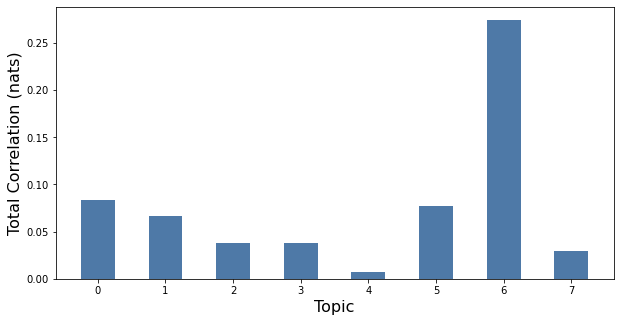

In [431]:
plt.figure(figsize=(10,5))
plt.bar(range(model.tcs.shape[0]), model.tcs, color='#4e79a7', width=0.5)
plt.xlabel('Topic', fontsize=16)
plt.ylabel('Total Correlation (nats)', fontsize=16);

# Topic Interpretation

## Topic keywords

In [643]:
# Show top n keywords for each topic
def show_topics(vectorizer=vectorizer, lda_model=lda, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

In [645]:
topic_keywords = show_topics(vectorizer, nmf, 15)
topic_keywords

[array(['work', 'walk', 'training', 'train', 'collar', 'leash', 'play',
        'bad', 'start', 'bite', 'help', 'treat', 'tell', 'park', 'pull'],
       dtype='<U29'),
 array(['hope', 'beautiful', 'heart', 'sweet', 'feel', 'friend', 'baby',
        'hug', 'hard', 'family', 'long', 'pain', 'home', 'wish', 'rest'],
       dtype='<U29'),
 array(['food', 'vet', 'eat', 'feed', 'help', 'diet', 'weight', 'allergy',
        'grain', 'chicken', 'free', 'raw', 'treat', 'start', 'grain free'],
       dtype='<U29'),
 array(['toy', 'chew', 'destroy', 'ball', 'play', 'long', 'buy', 'black',
        'bone', 'tooth', 'bite', 'treat', 'antler', 'hard', 'rope'],
       dtype='<U29'),
 array(['breeder', 'rescue', 'shelter', 'health', 'home', 'adopt',
        'reputable', 'test', 'litter', 'parent', 'vet', 'breeding',
        'reputable breeder', 'work', 'buy'], dtype='<U29'),
 array(['cute', 'ear', 'adorable', 'big', 'face', 'tail', 'baby',
        'beautiful', 'mix', 'eye', 'sweet', 'head', 'tell', 'yea

## Paradigmatic Docs

In [646]:
# add original comments text back into doc_topic matrix
df_doc_topic['orig_comments'] = df['body'].values
df_doc_topic

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,orig_comments
Comment_0,0.0000,0.0007,0.0000,0.0000,0.0000,0.0024,0.0000,0.0011,What's the new pupper's name? Utah
Comment_1,0.0000,0.0134,0.0000,0.0000,0.0000,0.0035,0.0000,0.0049,"Dude, she's beautiful!"
Comment_2,0.0000,0.0001,0.0000,0.0000,0.0000,0.0002,0.0000,0.0000,Wow. I would make that into a tattoo ����
Comment_3,0.0000,0.0000,0.0014,0.0023,0.0000,0.0134,0.0000,0.0000,A big puppy hah
Comment_4,0.0005,0.0000,0.0000,0.0001,0.0003,0.0006,0.0000,0.0000,Fair enough. Perish Sorry thought you someone ...
...,...,...,...,...,...,...,...,...,...
Comment_79063,0.0069,0.0215,0.0004,0.0000,0.0026,0.0012,0.0000,0.0000,Yes! If you don't mind telling a bit more...bu...
Comment_79064,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0583,That is the CONE OF HEALTH!! So happy for you ...
Comment_79065,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,Aww
Comment_79066,0.0008,0.0001,0.0002,0.0000,0.0000,0.0005,0.0015,0.0000,"Nuggets Mine was called ""puppy"" for the first ..."


In [647]:
def top_docs(df_doc_topic, topic, n_docs):
    return (df_doc_topic
            .sort_values(by=topic, ascending=False)
            .head(n_docs)['orig_comments']
            .values)

In [740]:
topic_docs = top_docs(df_doc_topic, 'Topic_6',3)
topic_docs

array(['Thanks! I wish I got it in my head earlier that crating them is not abuse and they enjoy it (if done right). Be prepared to be frustrated. He’ll be a lot to handle but he’ll slowly but surely calm down and be the best dog ever. Excited for you! Take 10000 pictures a day when they are puppies, it flies by so fast! Remember that’s he’s a baby. He will need potty breaks and extra loving. Get a big bottle of enzyme cleaner for accidents, and a large supply of paper towels. \n\nYou have a best friend for life! You’ll be a great mommy! \nPm me with any questions. ❤️�� I have this crate: https://www.amazon.com/dp/B000OX64P8/ref=cm_sw_r_cp_api_i_4Q2eDbX6EDW17\n\nIt’s big enough for your dog to fit into when he’s full grown. This crate has a divider, so you can section it off so your pup only has enough room to turn around and lay down in. This is supposed to keep them from going potty in it, because they typically won’t potty where they lay down. We used the crate for bedtime, and asso

## Explore topic distribution

In [649]:
df_doc_topic.iloc[:, : nmf.n_components]

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7
Comment_0,0.0000,0.0007,0.0000,0.0000,0.0000,0.0024,0.0000,0.0011
Comment_1,0.0000,0.0134,0.0000,0.0000,0.0000,0.0035,0.0000,0.0049
Comment_2,0.0000,0.0001,0.0000,0.0000,0.0000,0.0002,0.0000,0.0000
Comment_3,0.0000,0.0000,0.0014,0.0023,0.0000,0.0134,0.0000,0.0000
Comment_4,0.0005,0.0000,0.0000,0.0001,0.0003,0.0006,0.0000,0.0000
...,...,...,...,...,...,...,...,...
Comment_79063,0.0069,0.0215,0.0004,0.0000,0.0026,0.0012,0.0000,0.0000
Comment_79064,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0583
Comment_79065,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
Comment_79066,0.0008,0.0001,0.0002,0.0000,0.0000,0.0005,0.0015,0.0000


In [650]:
# identify dominant topic for each doc
df_doc_topic['dominant_topic'] = np.argmax(df_doc_topic.iloc[:, : nmf.n_components].values, axis=1)
df_doc_topic.head(2)

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,orig_comments,dominant_topic
Comment_0,0.0,0.0007,0.0,0.0,0.0,0.0024,0.0,0.0011,What's the new pupper's name? Utah,5
Comment_1,0.0,0.0134,0.0,0.0,0.0,0.0035,0.0,0.0049,"Dude, she's beautiful!",1


In [651]:
# average probability of each topic
df_doc_topic.iloc[:, : nmf.n_components].mean(axis=0).round(3)

Topic_0    0.012
Topic_1    0.017
Topic_2    0.011
Topic_3    0.008
Topic_4    0.008
Topic_5    0.024
Topic_6    0.013
Topic_7    0.013
dtype: float64

In [652]:
# add subreddit into the doc_topic matrix for comparison across subs
df_doc_topic['subreddit'] = df['subreddit'].values
df_doc_topic.head(2)

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,orig_comments,dominant_topic,subreddit
Comment_0,0.0,0.0007,0.0,0.0,0.0,0.0024,0.0,0.0011,What's the new pupper's name? Utah,5,goldenretrievers
Comment_1,0.0,0.0134,0.0,0.0,0.0,0.0035,0.0,0.0049,"Dude, she's beautiful!",1,pitbulls


In [713]:
# create groupby aggregation dictionary
topics_cols = list(df_doc_topic.columns[:nmf.n_components])
topics_agg_dict = {t:'mean' for t in topics_cols}

# get average probability of each topic by breed
topic_avg_per_breed = df_doc_topic.groupby('subreddit').agg(topics_agg_dict).round(3)*100
topic_avg_per_breed.columns = ['leash training','love & loss','diet','chew toys','acquisition','face cuteness',
                              'home training','general happiness']

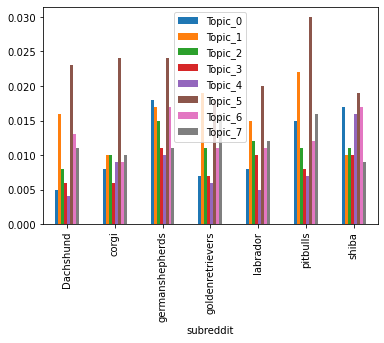

In [655]:
# plot average probability of each topic by breed
df_doc_topic.groupby('subreddit').agg(topics_agg_dict).round(3).plot(kind='bar');

In [736]:
#now make an easier-to-read dot chart version
from pygal.style import DefaultStyle
dot_chart = pygal.Dot(x_label_rotation=30,width=1100,height=550,background='transparent')
dot_chart.x_labels = topic_avg_per_breed.columns
for ix,values in topic_avg_per_breed.iterrows():
    dot_chart.add(ix, values)

dot_chart.render_in_browser()
dot_chart.render_to_png('dot_chart.png')

file:///var/folders/vb/189dd8b50xx65gllpj0mgh5m0000gn/T/tmpdygrm5bs.html


In [684]:
# calculate the dimensions of bars for ppt presentation (bar chart where longest bar = 18 inches)
df_bar_dims = df_doc_topic['dominant_topic'].value_counts(normalize=True).round(2).reset_index()
df_bar_dims.columns=["topic_num","freq"]
df_bar_dims['percent_of_max'] = df_bar_dims['freq'] / np.max(df_bar_dims['freq'])
df_bar_dims['bar_dim'] = df_bar_dims['percent_of_max']*18
df_bar_dims

,topic_num,freq,percent_of_max,bar_dim
0,5,0.37,1.000000,18.000000
1,1,0.17,0.459459,8.270270
2,0,0.16,0.432432,7.783784
3,6,0.09,0.243243,4.378378
4,7,0.07,0.189189,3.405405
5,2,0.05,0.135135,2.432432
6,3,0.05,0.135135,2.432432
7,4,0.04,0.108108,1.945946


In [741]:
# Topic - Keyword matrix
df_topic_keywords = pd.DataFrame(nmf.components_)

# assign column and index
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.index = topicnames

df_topic_keywords.iloc[:,:10]

,abandon,abandonment,abdoman,abdominal,abide,abide strict,ability,abit,able,able adopt
Topic_0,0.040988,0.007839,0.000000,0.000000,0.000000,0.000000,0.153651,0.000000,0.834095,0.002720
Topic_1,0.090083,0.003973,0.020557,0.003049,0.000000,0.000000,0.057180,0.000000,0.848418,0.010356
Topic_2,0.000000,0.000000,0.001656,0.003369,0.000000,0.000000,0.007554,0.005444,0.300082,0.000000
Topic_3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.131713,0.000000
Topic_4,0.082527,0.006009,0.000000,0.002572,0.086161,0.083048,0.132494,0.000000,0.567390,0.014089
Topic_5,0.029717,0.000000,0.000000,0.002904,0.000000,0.000000,0.044162,0.003812,0.000000,0.002368
Topic_6,0.009346,0.004075,0.000662,0.000000,0.000000,0.000000,0.004492,0.000000,0.437229,0.005143
Topic_7,0.082881,0.000000,0.000000,0.001609,0.000000,0.000000,0.000000,0.000000,0.107703,0.004552
